In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_experiments.library import LocalReadoutError, CorrelatedReadoutError

from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakePerth

from qiskit.result.mitigation.utils import (
    expval_with_stddev,
    str2diag,
    counts_probability_vector
)

backend = AerSimulator.from_backend(FakePerth())


In [2]:
shots = 1024
qubits = [0,1,2,3]
num_qubits = len(qubits)

In [3]:
exp = LocalReadoutError(qubits)
for c in exp.circuits():
    print(c)

         ░ ┌─┐         
   q_0: ─░─┤M├─────────
         ░ └╥┘┌─┐      
   q_1: ─░──╫─┤M├──────
         ░  ║ └╥┘┌─┐   
   q_2: ─░──╫──╫─┤M├───
         ░  ║  ║ └╥┘┌─┐
   q_3: ─░──╫──╫──╫─┤M├
         ░  ║  ║  ║ └╥┘
meas: 4/════╩══╩══╩══╩═
            0  1  2  3 
        ┌───┐ ░ ┌─┐         
   q_0: ┤ X ├─░─┤M├─────────
        ├───┤ ░ └╥┘┌─┐      
   q_1: ┤ X ├─░──╫─┤M├──────
        ├───┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ X ├─░──╫──╫─┤M├───
        ├───┤ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ X ├─░──╫──╫──╫─┤M├
        └───┘ ░  ║  ║  ║ └╥┘
meas: 4/═════════╩══╩══╩══╩═
                 0  1  2  3 


In [4]:
exp.analysis.set_options(plot=True)
result = exp.run(backend)
mitigator = result.analysis_results(0).value

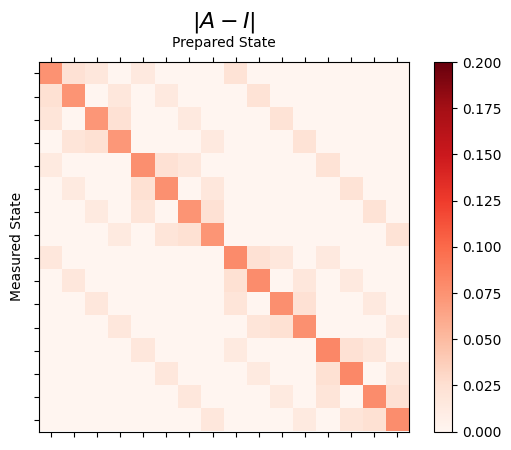

In [5]:
result.figure(0)

In [6]:
for m in mitigator._mitigation_mats:
    print(m)
    print()

[[ 1.02672148 -0.02569373]
 [-0.02672148  1.02569373]]

[[ 1.0213198  -0.01827411]
 [-0.0213198   1.01827411]]

[[ 1.01408451 -0.01609658]
 [-0.01408451  1.01609658]]

[[ 1.01831129 -0.02339776]
 [-0.01831129  1.02339776]]



In [7]:
qc = QuantumCircuit(num_qubits)
qc.h(0)
for i in range(1, num_qubits):
    qc.cx(i - 1, i)
qc.measure_all()

In [8]:

counts = backend.run(qc, shots=shots, seed_simulator=42, method="density_matrix").result().get_counts()
unmitigated_probs = {label: count / shots for label, count in counts.items()}

In [9]:
mitigated_quasi_probs = mitigator.quasi_probabilities(counts)
mitigated_stddev = mitigated_quasi_probs._stddev_upper_bound
mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())

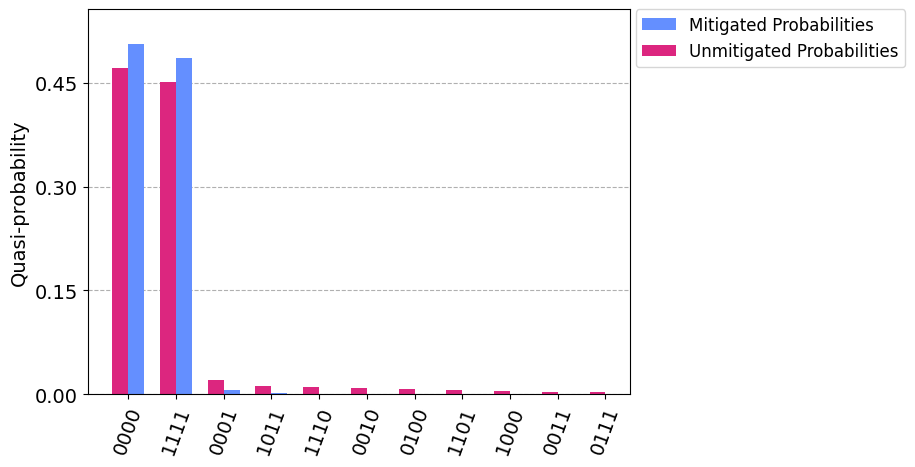

In [10]:
legend = ['Mitigated Probabilities', 'Unmitigated Probabilities']
plot_histogram([mitigated_probs, unmitigated_probs], legend=legend, sort="value_desc", bar_labels=False)

In [11]:
diagonal_labels = ["YZZZ", "ZIZI", "IZII", "1ZZ0"]
ideal_expectation = []
diagonals = [str2diag(d) for d in diagonal_labels]
qubit_index = {i: i for i in range(num_qubits)}
unmitigated_probs_vector, _ = counts_probability_vector(unmitigated_probs, qubit_index=qubit_index)
unmitigated_expectation = [expval_with_stddev(d, unmitigated_probs_vector, shots) for d in diagonals]
mitigated_expectation = [mitigator.expectation_value(counts, d) for d in diagonals]